In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install umap-learn

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.2 MB/s eta 0:00:00


# Functions

In [4]:
def static_correlation_matrices(data_list):
    """ This function calculate the static correlation matrices
    of the subjects in data_list.
    Parameters:
    data_list: list of dicts [dict(),..] each dict contains the singnals of the subjects
    returns:
    corr_matrices: list of numpy arrays
    """
    corr_matrices = []
    for subj in data_list:
        bold = subj["bold"]
        corr_matrix = np.corrcoef(bold.T)
        corr_matrices.append(corr_matrix)
    return corr_matrices

In [5]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from functools import partial

def objective(trial, X_scaled, labels,seed):
    # sugerencias de hiperparámetros
    n_neighbors = trial.suggest_int("n_neighbors", 5, 98)
    min_dist = trial.suggest_float("min_dist", 0.0, 0.9)
    n_components = trial.suggest_int("n_components", 2, 50)
    metric = trial.suggest_categorical("metric", ["cosine", "correlation", "euclidean"])

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=seed
    )
    Z = reducer.fit_transform(X_scaled)

    clf = LogisticRegression(max_iter=1000)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    acc = cross_val_score(clf, Z, labels, cv=cv, scoring="accuracy").mean()
    return acc


In [6]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden.*")
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import optuna.visualization as vis

# plot the borders beetween groups in the visualization of PCA
def plot_lr_boundary_on_2d(Z2, y, C=1.0, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(7,6))
    clf2d = LogisticRegression(C=C, max_iter=1000)
    clf2d.fit(Z2, y)

    x_min, x_max = Z2[:,0].min()-0.5, Z2[:,0].max()+0.5
    y_min, y_max = Z2[:,1].min()-0.5, Z2[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    proba = clf2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    cf = ax.contourf(xx, yy, proba, levels=np.linspace(0,1,21),
                     cmap="coolwarm", alpha=0.30)
    ax.contour(xx, yy, proba, levels=[0.5], colors='k', linewidths=2)

    return clf2d, cf


def optimal_params_UMAP(dataset, labels, components= None, study=True,seed=None):
    """Search the optimal parameters of UMAP and show the embeddings
    parameters:
    dataset: [dict()] each dict is a subject
    labels: array size len(dataset)
    seed: int
    returns:
    embedding: the UMAP model
    reducer: the UMAP model
    labels: array size len(dataset)
    params: dict with the optimal parameters

    """
    corr_matrices = static_correlation_matrices(dataset)

    # Preprocessing of the static FC
    # vectorize only the upper part of the matrix
    R = corr_matrices[0].shape[0]
    idx_upper = np.triu_indices(R, k=1)
    X = np.array([fc[idx_upper] for fc in corr_matrices])

    # scale
    X_scaled = StandardScaler().fit_transform(X)

    np.random.seed(seed)
    random.seed(seed)
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    if study == True:
        sampler = optuna.samplers.TPESampler(seed=seed)
        study = optuna.create_study(direction="maximize", sampler=sampler)

        objective_partial = partial(objective, X_scaled=X_scaled, labels=labels, seed=seed)
        study.optimize(objective_partial, n_trials=100)

        vis.plot_optimization_history(study).show()
        vis.plot_param_importances(study).show()

        # params = study.best_params
        sorted_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)

        # top 3
        top3 = sorted_trials[:3]
        for i, trial in enumerate(top3):
            params = trial.params
            reducer = umap.UMAP(
              n_neighbors=params["n_neighbors"],
              min_dist=params["min_dist"],
              n_components=params["n_components"],
              metric=params["metric"],
              random_state=seed
              )
            embedding = reducer.fit_transform(X_scaled)

            # Classification metrics
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
            clf_full = LogisticRegression(max_iter=1000)
            acc_full = cross_val_score(clf_full, embedding, labels, cv=cv, scoring='accuracy').mean()
            auc_full = cross_val_score(clf_full, embedding, labels, cv=cv, scoring='roc_auc').mean()

            # PCA visualization

            pca = PCA(n_components=2)
            Z_pca = pca.fit_transform(embedding)

            fig, ax = plt.subplots(figsize=(7,6))

            clf2d, cf = plot_lr_boundary_on_2d(Z_pca, labels, C=1.0, ax=ax)
            colors = ['steelblue' if l==0 else 'tomato' for l in labels]
            plt.scatter(Z_pca[:,0], Z_pca[:,1], c=colors, s=60, alpha=0.8, edgecolor='k')

            plt.title(f"TOP {i+1} embedding ({params['n_components']}D UMAP) Acc={acc_full:.3f} AUC={auc_full:.3f}")
            plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
            plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
            text_str = (
              f"n_neighbors = {params['n_neighbors']},  "
              f"min_dist = {params['min_dist']:.2f},  "
              f"n_components = {params['n_components']},  "
              f"metric = {params['metric']}"
              )

            plt.figtext(0.5, -0.05, text_str, wrap=True, ha="center", fontsize=10, color="dimgray")
            plt.tight_layout()
            plt.show()

        params = study.best_trial.params

        reducer = umap.UMAP(
              n_neighbors=params["n_neighbors"],
              min_dist=params["min_dist"],
              n_components=params["n_components"],
              metric=params["metric"],
              random_state=seed
              )
        embedding = reducer.fit_transform(X_scaled)
    else:
        print("no study")

    return embedding, reducer, labels, params

# UMAP embedding in the dataset 1

### Load the dataset 1

In [7]:
import os
import numpy as np

# Path
folder1 = "/content/drive/MyDrive/Balloon_model/Data1/Group1"
folder2 = "/content/drive/MyDrive/Balloon_model/Data1/Group2"

# List of .npz files
files1 = [f for f in os.listdir(folder1) if f.startswith("10ROI") and f.endswith(".npz")] # data with 10 ROIs
files1.sort()

files2 = [f for f in os.listdir(folder2) if f.startswith("10ROI") and f.endswith(".npz")] # data with 10 ROIs
files2.sort()

# load all the files
data_list1 = []
for file in files1:
    path = os.path.join(folder1, file)
    with np.load(path, allow_pickle=True) as data:
        data_list1.append({k: data[k] for k in data.files})

print(f"{len(data_list1)} archivos cargados correctamente.")

data_list2 = []
for file in files2:
    path = os.path.join(folder2, file)
    with np.load(path, allow_pickle=True) as data:
        data_list2.append({k: data[k] for k in data.files})

print(f"{len(data_list2)} archivos cargados correctamente.")

400 archivos cargados correctamente.
400 archivos cargados correctamente.


### Show the top 3 embedding with UMAP

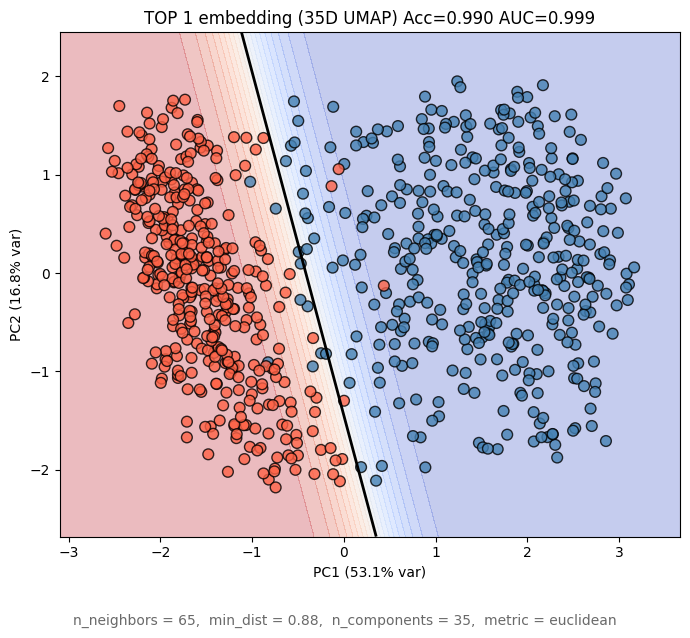

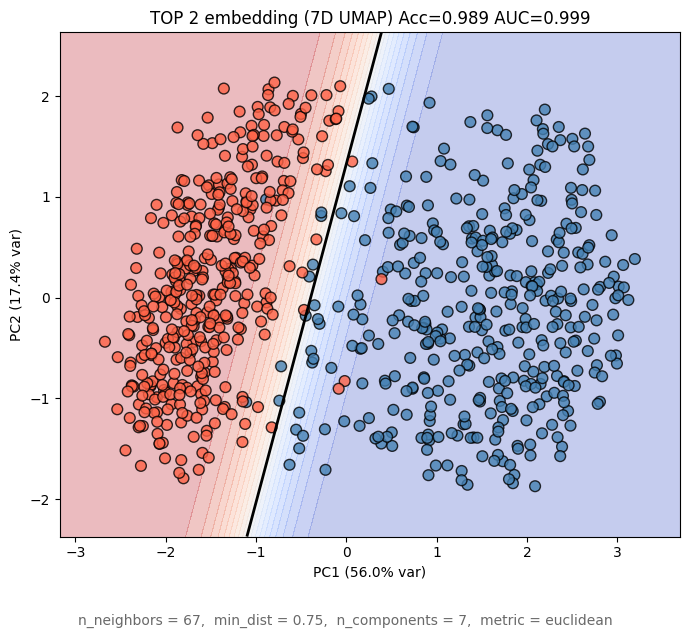

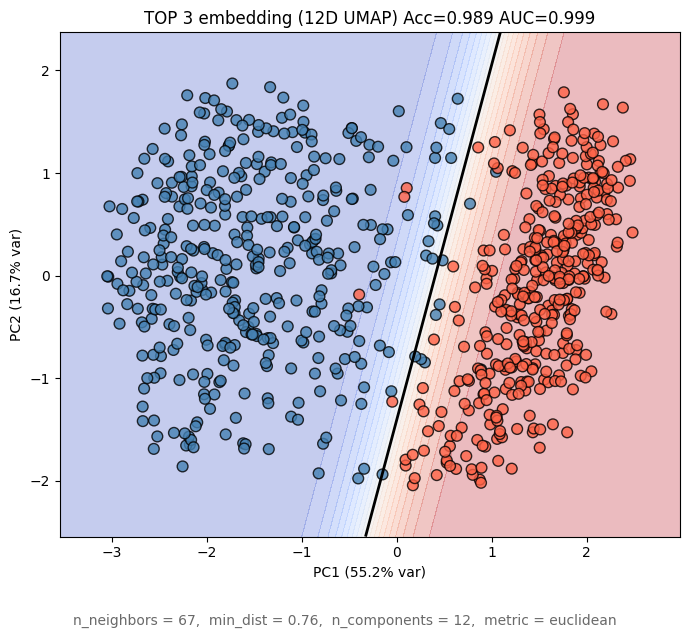

In [8]:
data_list = data_list1 + data_list2 # combine the groups
labels = np.array([0]*len(data_list1) + [1]*len(data_list2))  # 0 = group1, 1 = group2
#corr_matrices = static_correlation_matrices(data_list)
embedding, reducer, labels, params = optimal_params_UMAP(data_list, labels, study=True, seed=40)

# UMAP embedding in the dataset 2

### Load the dataset 2

In [9]:
import os
import numpy as np

# Path
folder1 = "/content/drive/MyDrive/Balloon_model/Data2/Group1"
folder2 = "/content/drive/MyDrive/Balloon_model/Data2/Group2"

# List of .npz files
files1 = [f for f in os.listdir(folder1) if f.startswith("10ROI") and f.endswith(".npz")] # data with 10 ROIs
files1.sort()

files2 = [f for f in os.listdir(folder2) if f.startswith("10ROI") and f.endswith(".npz")] # data with 10 ROIs
files2.sort()

# load all the files
data_list1 = []
for file in files1:
    path = os.path.join(folder1, file)
    with np.load(path, allow_pickle=True) as data:
        data_list1.append({k: data[k] for k in data.files})

print(f"{len(data_list1)} archivos cargados correctamente.")

data_list2 = []
for file in files2:
    path = os.path.join(folder2, file)
    with np.load(path, allow_pickle=True) as data:
        data_list2.append({k: data[k] for k in data.files})

print(f"{len(data_list2)} archivos cargados correctamente.")

400 archivos cargados correctamente.
400 archivos cargados correctamente.


### Show the top 3 embedding with UMAP

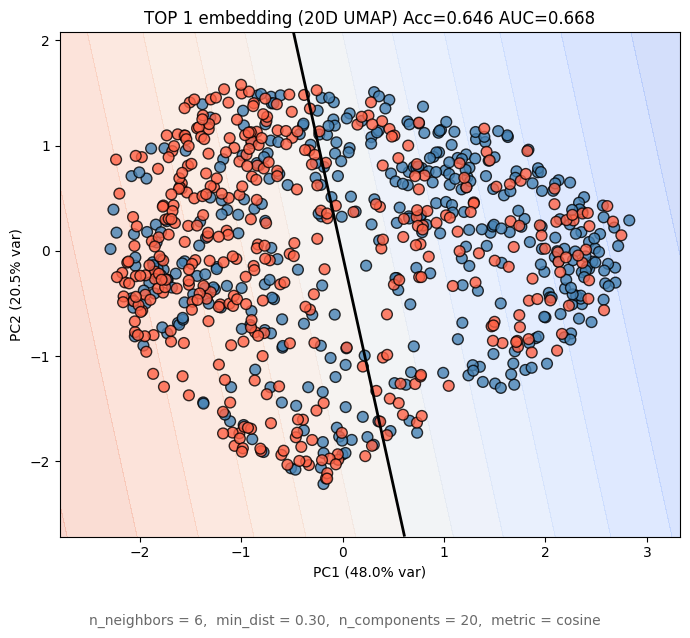

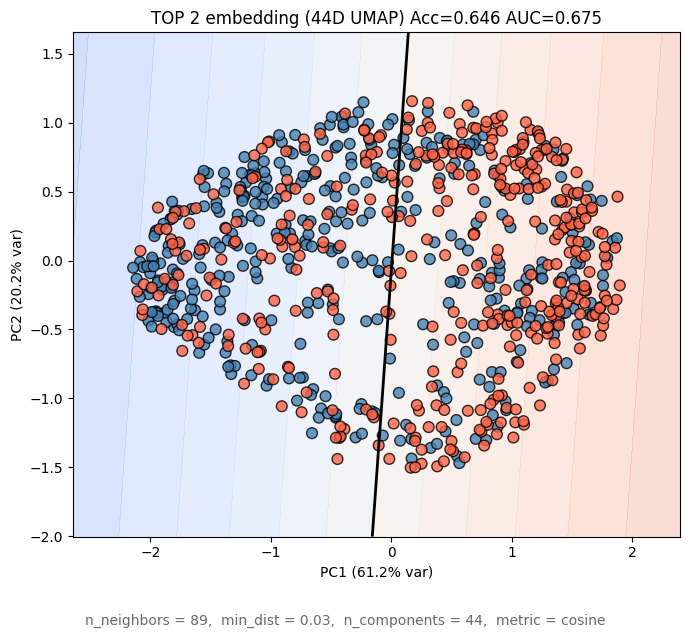

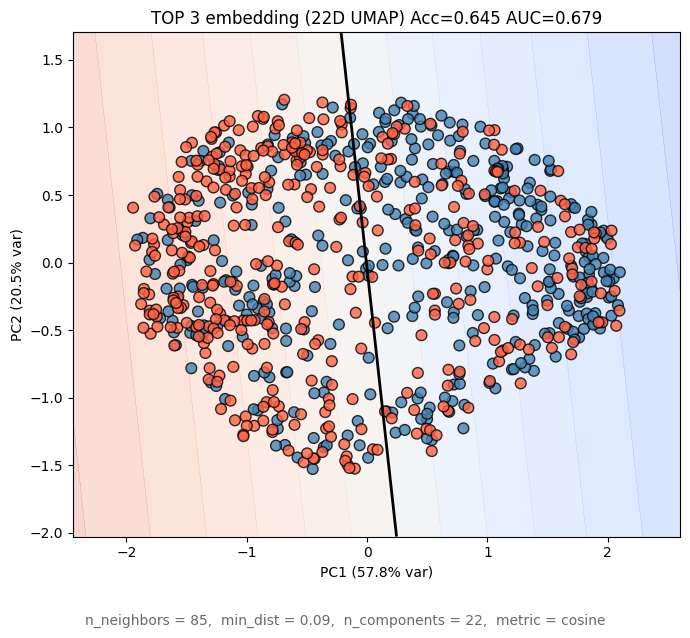

In [10]:
data_list = data_list1 + data_list2 # combine the groups
labels = np.array([0]*len(data_list1) + [1]*len(data_list2))  # 0 = group1, 1 = group2
#corr_matrices = static_correlation_matrices(data_list)
embedding, reducer, labels, params = optimal_params_UMAP(data_list, labels, study=True, seed=40)

# UMAP embedding in the dataset 3

### Load the dataset 3

In [11]:
import os
import numpy as np

# Path
folder1 = "/content/drive/MyDrive/Balloon_model/Data3/Group1"
folder2 = "/content/drive/MyDrive/Balloon_model/Data3/Group2"

# List of .npz files
files1 = [f for f in os.listdir(folder1) if f.startswith("10ROI") and f.endswith(".npz")] # data with 10 ROIs
files1.sort()

files2 = [f for f in os.listdir(folder2) if f.startswith("10ROI") and f.endswith(".npz")] # data with 10 ROIs
files2.sort()

# load all the files
data_list1 = []
for file in files1:
    path = os.path.join(folder1, file)
    with np.load(path, allow_pickle=True) as data:
        data_list1.append({k: data[k] for k in data.files})

print(f"{len(data_list1)} archivos cargados correctamente.")

data_list2 = []
for file in files2:
    path = os.path.join(folder2, file)
    with np.load(path, allow_pickle=True) as data:
        data_list2.append({k: data[k] for k in data.files})

print(f"{len(data_list2)} archivos cargados correctamente.")

400 archivos cargados correctamente.
400 archivos cargados correctamente.


### Show the top 3 embedding with UMAP

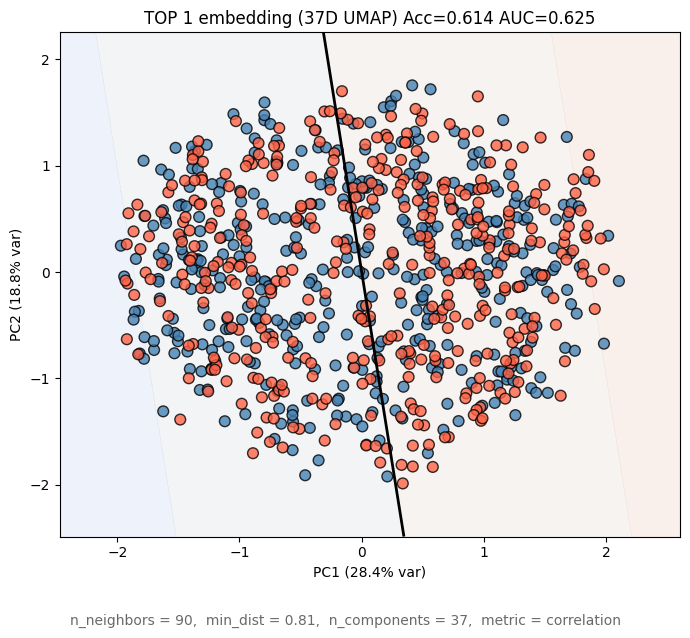

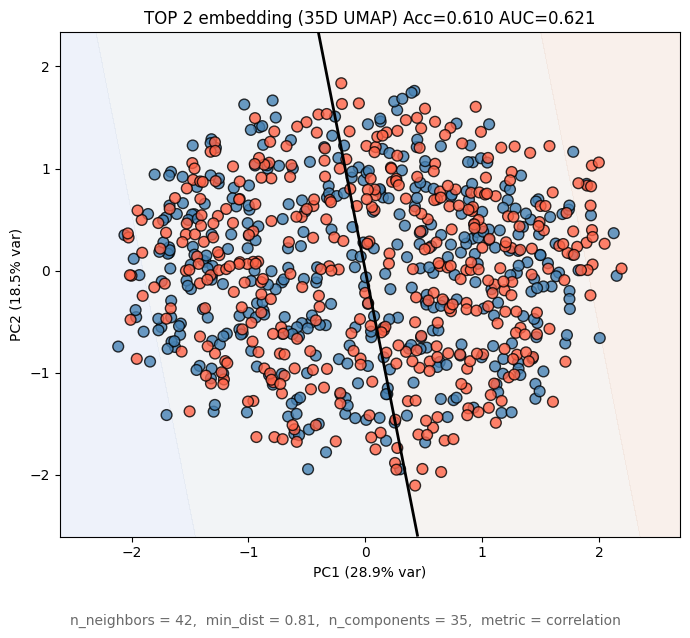

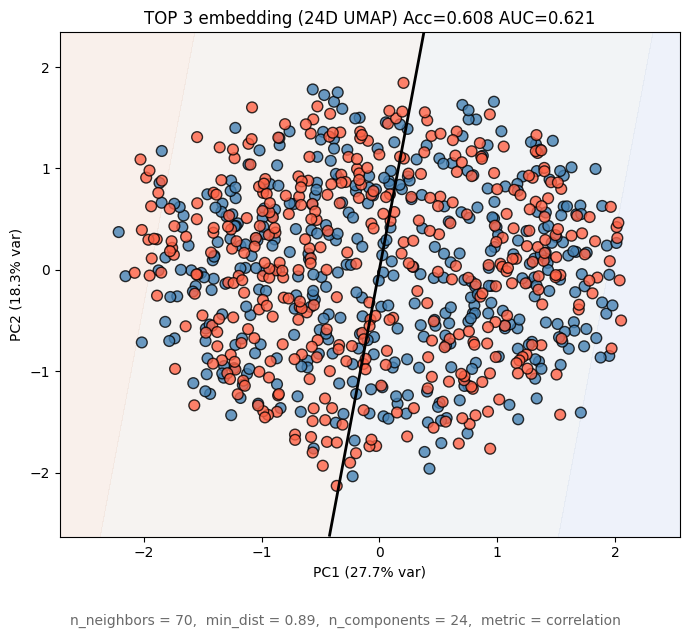

In [12]:
data_list = data_list1 + data_list2 # combine the groups
labels = np.array([0]*len(data_list1) + [1]*len(data_list2))  # 0 = group1, 1 = group2
#corr_matrices = static_correlation_matrices(data_list)
embedding, reducer, labels, params = optimal_params_UMAP(data_list, labels, study=True, seed=40)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def eval_clf(Z, y, cv):
    results = {}
    lr = LogisticRegression(max_iter=1000)
    svm = SVC(kernel="rbf", probability=True)
    for name, clf in [("LogReg", lr), ("SVM-RBF", svm)]:
        acc = cross_val_score(clf, Z, y, cv=cv, scoring="accuracy").mean()
        auc = cross_val_score(clf, Z, y, cv=cv, scoring="roc_auc").mean()
        results[name] = {"acc": acc, "auc": auc}
    return results

#print("UMAP no supervisado:", eval_clf(embedding, labels, cv))
#print("UMAP supervisado:",   eval_clf(Z,   labels))
